In [23]:
# ========================================================================
# SECTION 0: SETUP
# ========================================================================
import os, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications import EfficientNetV2B0, ResNet50

# Mixed precision for GPU memory optimization
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

BASE_PATH = "/kaggle/input/skin-cancer-mnist-ham10000/"
CSV_PATH = os.path.join(BASE_PATH, "HAM10000_metadata.csv")

IMAGE_SIZE = 224
BATCH_SIZE = 32
FEATURE_EXTRACTION_EPOCHS = 15
FINE_TUNING_EPOCHS = 10
LEARNING_RATE_HEAD = 1e-3
LEARNING_RATE_FINE_TUNE = 1e-5
LABEL_SMOOTHING = 0.1
AUTOTUNE = tf.data.AUTOTUNE


In [24]:
# ========================================================================
# SECTION 1: DATA LOADING
# ========================================================================
print("\n--- Loading and preparing data...")

df = pd.read_csv(CSV_PATH)
dir1 = os.path.join(BASE_PATH, "HAM10000_images_part_1")
dir2 = os.path.join(BASE_PATH, "HAM10000_images_part_2")

df["path"] = df["image_id"].apply(
    lambda x: os.path.join(dir1 if os.path.exists(os.path.join(dir1, x + ".jpg")) else dir2, x + ".jpg")
)
df = df.dropna(subset=["path"])
label_columns = sorted(df["dx"].unique())
NUM_CLASSES = len(label_columns)

# One-hot encode
df = pd.concat([df, pd.get_dummies(df["dx"], dtype="float32")], axis=1)

train_df, validation_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["dx"]
)

print(f"Train samples: {len(train_df)},  Validation samples: {len(validation_df)}")



--- Loading and preparing data...
Train samples: 8012,  Validation samples: 2003


In [25]:
# ========================================================================
# SECTION 2: TF.DATA PIPELINE
# ========================================================================
print("\n--- Building tf.data pipelines...")

def parse_image(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_df["path"].values, train_df[label_columns].values))
    .shuffle(buffer_size=len(train_df))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

validation_dataset = (
    tf.data.Dataset.from_tensor_slices((validation_df["path"].values, validation_df[label_columns].values))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)



--- Building tf.data pipelines...


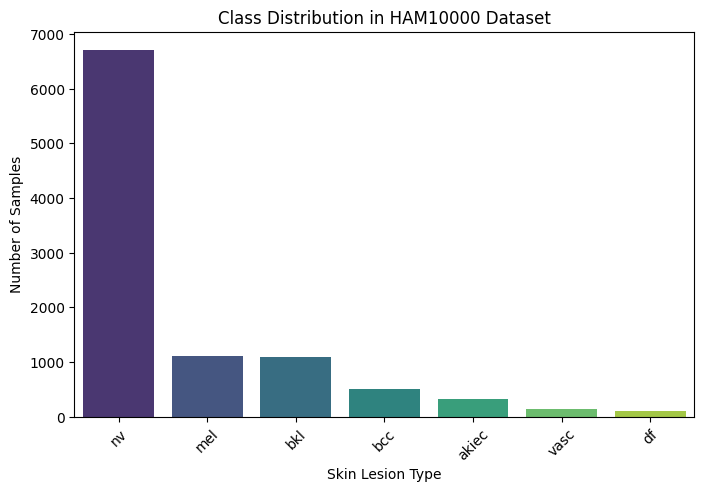

Class distribution:
 dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [15]:
# ========================================================================
# SECTION 3: EFFICIENTNETV2B0
# ========================================================================
print("\n--- Building and training EfficientNetV2B0 model...")

base_model = EfficientNetV2B0(include_top=False, weights="imagenet", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = False

inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)
model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_HEAD),
    loss=CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=["accuracy"]
)

history_head = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=FEATURE_EXTRACTION_EPOCHS,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
    verbose=1
)

# Fine-tuning
print("\n--- Fine-tuning EfficientNetV2B0 ---")
base_model.trainable = True
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_FINE_TUNE),
    loss=CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=["accuracy"]
)

history_fine_tune = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=FEATURE_EXTRACTION_EPOCHS + FINE_TUNING_EPOCHS,
    initial_epoch=len(history_head.history["loss"]),
    callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
    verbose=1
)


In [27]:
# ========================================================================
# SECTION 3: EFFICIENTNETV2B0
# ========================================================================
print("\n--- Building and training EfficientNetV2B0 model...")

base_model = EfficientNetV2B0(include_top=False, weights="imagenet", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = False

inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)
model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_HEAD),
    loss=CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=["accuracy"]
)

history_head = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=FEATURE_EXTRACTION_EPOCHS,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
    verbose=1
)

# Fine-tuning
print("\n--- Fine-tuning EfficientNetV2B0 ---")
base_model.trainable = True
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_FINE_TUNE),
    loss=CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=["accuracy"]
)

history_fine_tune = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=FEATURE_EXTRACTION_EPOCHS + FINE_TUNING_EPOCHS,
    initial_epoch=len(history_head.history["loss"]),
    callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
    verbose=1
)



--- Building and training EfficientNetV2B0 model...
Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 196ms/step - accuracy: 0.6345 - loss: 1.2700 - val_accuracy: 0.7184 - val_loss: 1.0210
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.7239 - loss: 1.0257 - val_accuracy: 0.7244 - val_loss: 0.9973
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.7471 - loss: 0.9853 - val_accuracy: 0.7479 - val_loss: 0.9742
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.7412 - loss: 0.9867 - val_accuracy: 0.7439 - val_loss: 0.9634
Epoch 5/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.7542 - loss: 0.9652 - val_accuracy: 0.7474 - val_loss: 0.9535
Epoch 6/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.7580 - loss: 0.9546 - val_accuracy: 0.7564 - val_loss: 0.9454
Epoch 7/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.7574 - loss: 0.9555 - val_accuracy: 0.7554 - val_loss: 0.9459
Epoch 8/15
251/251 ━━━━━━━━━━━━━━━━━


--- Evaluating EfficientNetV2B0 ---


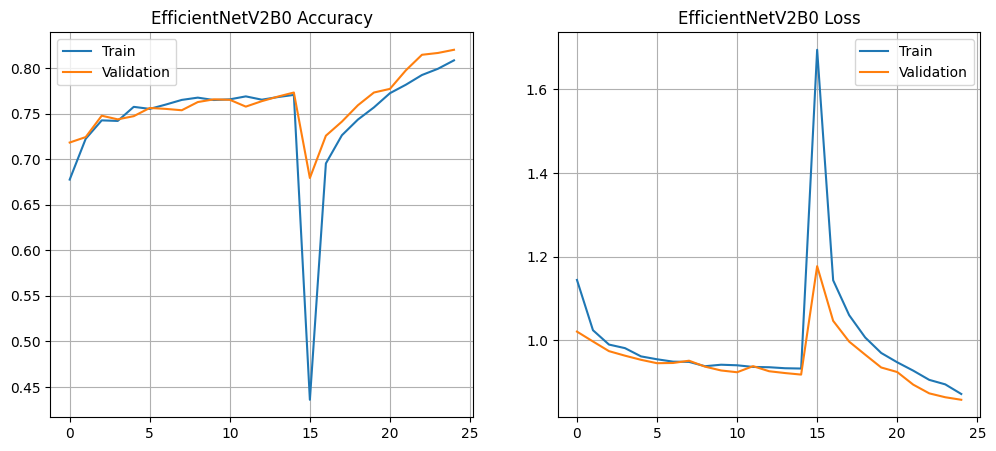

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━

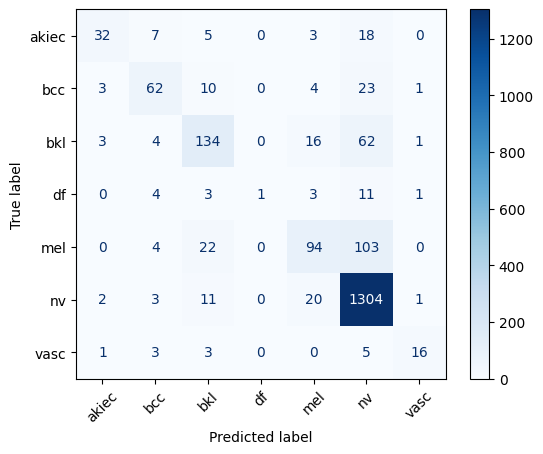

0

In [28]:
# ========================================================================
# SECTION 4: EVALUATION - EFFICIENTNETV2B0
# ========================================================================
print("\n--- Evaluating EfficientNetV2B0 ---")

combined_history = {
    k: history_head.history[k] + history_fine_tune.history[k] for k in history_head.history.keys()
}

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(combined_history["accuracy"], label="Train")
plt.plot(combined_history["val_accuracy"], label="Validation")
plt.title("EfficientNetV2B0 Accuracy")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(combined_history["loss"], label="Train")
plt.plot(combined_history["val_loss"], label="Validation")
plt.title("EfficientNetV2B0 Loss")
plt.legend(); plt.grid(True)
plt.show()

y_true, y_pred = [], []
for images, labels in validation_dataset:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report (EfficientNetV2B0):")
print(classification_report(y_true, y_pred, target_names=label_columns))
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=label_columns).plot(cmap="Blues", xticks_rotation=45)
plt.show()

tf.keras.backend.clear_session(); gc.collect()


In [29]:
# ========================================================================
# SECTION 5: RESNET50
# ========================================================================
print("\n--- Building and training ResNet50 model...")

base_model_resnet = ResNet50(include_top=False, weights="imagenet", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model_resnet.trainable = False

x = GlobalAveragePooling2D()(base_model_resnet.output)
x = Dropout(0.4)(x)
output_layer = Dense(NUM_CLASSES, activation="softmax")(x)
resnet_model = Model(inputs=base_model_resnet.input, outputs=output_layer)

resnet_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_HEAD),
    loss=CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=["accuracy"]
)

history_resnet_head = resnet_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=FEATURE_EXTRACTION_EPOCHS,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
    verbose=1
)

print("\n--- Fine-tuning ResNet50 ---")
base_model_resnet.trainable = True
resnet_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_FINE_TUNE),
    loss=CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=["accuracy"]
)

history_resnet_finetune = resnet_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=FEATURE_EXTRACTION_EPOCHS + FINE_TUNING_EPOCHS,
    initial_epoch=len(history_resnet_head.history["loss"]),
    callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
    verbose=1
)



--- Building and training ResNet50 model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 58s 171ms/step - accuracy: 0.6201 - loss: 1.4612 - val_accuracy: 0.7329 - val_loss: 1.0432
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - accuracy: 0.7180 - loss: 1.0788 - val_accuracy: 0.7449 - val_loss: 0.9815
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 29s 113ms/step - accuracy: 0.7458 - loss: 1.0066 - val_accuracy: 0.7444 - val_loss: 0.9930
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.7510 - loss: 1.0046 - val_accuracy: 0.7519 - val_loss: 0.9719
Epoch 5/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 29s 114ms/step - accuracy: 0.7578 - loss: 0.9799 - val_accuracy: 0.7683 - val_loss: 0.9587
Epoch 6/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - accuracy: 0.7554 - loss: 0.9795 - val_accuracy: 0.7619 - val_loss: 0.9768
Epoch 7/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - accuracy: 0.7521 - loss: 0.9808 - val_accuracy: 0.7753 - val_


--- Evaluating ResNet50 ---


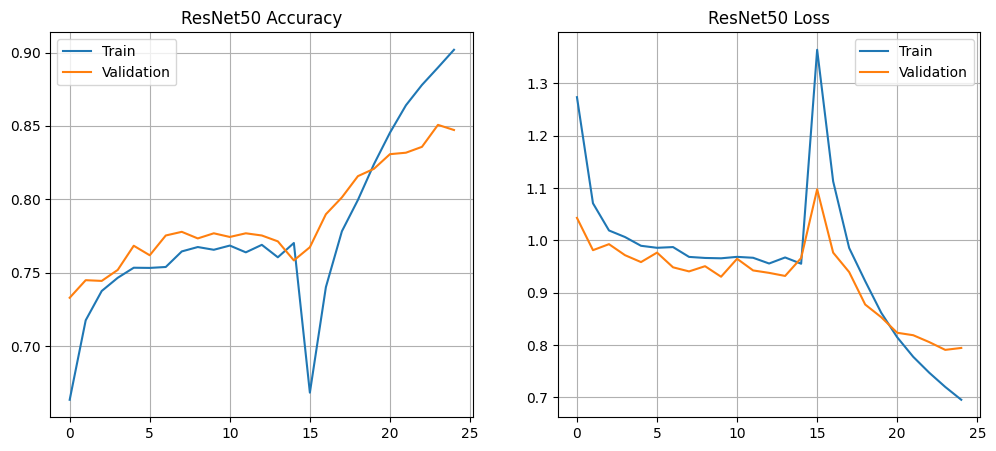

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

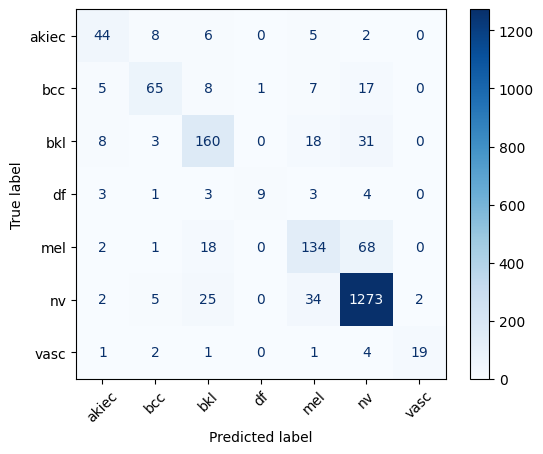


✅ Fine-tuning complete for both models.


In [30]:
# ========================================================================
# SECTION 6: EVALUATION - RESNET50
# ========================================================================
print("\n--- Evaluating ResNet50 ---")

combined_resnet = {
    k: history_resnet_head.history[k] + history_resnet_finetune.history[k]
    for k in history_resnet_head.history.keys()
}

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(combined_resnet["accuracy"], label="Train")
plt.plot(combined_resnet["val_accuracy"], label="Validation")
plt.title("ResNet50 Accuracy")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(combined_resnet["loss"], label="Train")
plt.plot(combined_resnet["val_loss"], label="Validation")
plt.title("ResNet50 Loss")
plt.legend(); plt.grid(True)
plt.show()

y_true, y_pred = [], []
for images, labels in validation_dataset:
    preds = resnet_model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report (ResNet50):")
print(classification_report(y_true, y_pred, target_names=label_columns))
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=label_columns).plot(cmap="Blues", xticks_rotation=45)
plt.show()

print("\n✅ Fine-tuning complete for both models.")


In [31]:
import os

# Create output directory
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# File paths
efficientnet_path = os.path.join(SAVE_DIR, "EfficientNetV2B0_skin_cancer.h5")
resnet_path = os.path.join(SAVE_DIR, "ResNet50_skin_cancer.h5")

# Save models
model.save(efficientnet_path)
resnet_model.save(resnet_path)

print(f"✅ Models saved successfully!")
print(f"EfficientNetV2B0 saved at: {efficientnet_path}")
print(f"ResNet50 saved at:        {resnet_path}")

# Optional: list saved files
!ls -lh {SAVE_DIR}


✅ Models saved successfully!
EfficientNetV2B0 saved at: /kaggle/working/saved_models/EfficientNetV2B0_skin_cancer.h5
ResNet50 saved at:        /kaggle/working/saved_models/ResNet50_skin_cancer.h5
total 339M
-rw-r--r-- 1 root root  69M Nov  6 02:55 EfficientNetV2B0_skin_cancer.h5
-rw-r--r-- 1 root root 271M Nov  6 02:55 ResNet50_skin_cancer.h5


✅ Generating Grad-CAM overlays for EfficientNetV2B0...


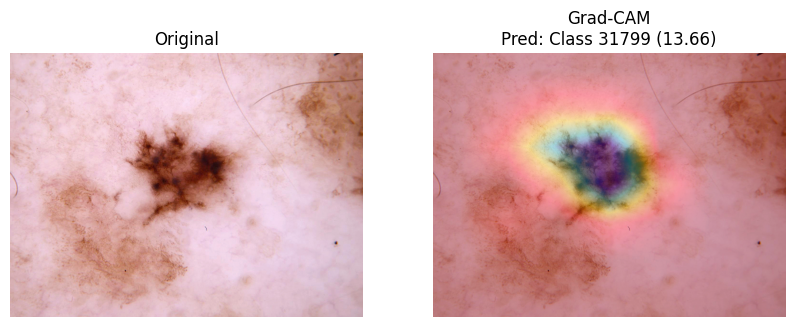

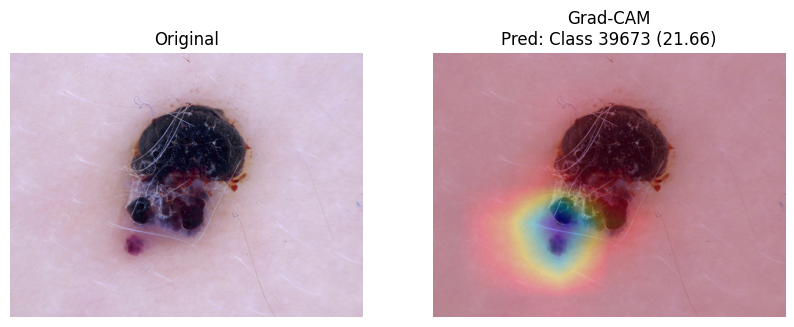

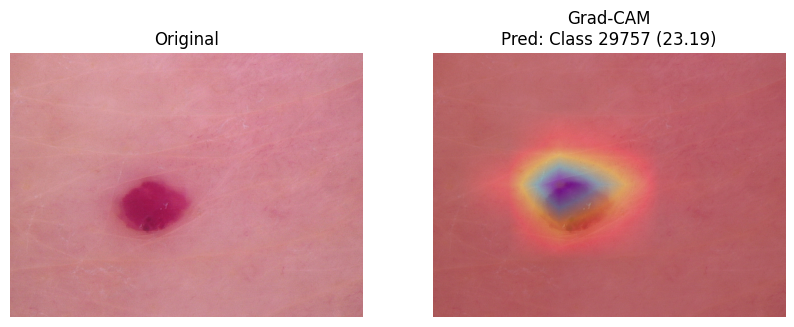

In [60]:
# ========================================================================
# ✅ FINAL GRAD-CAM (ERROR-FREE, AUTO-ADAPTIVE) FOR EFFICIENTNETV2B0
# ========================================================================
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

def get_img_array(img_path, size=(224,224)):
    """Load and preprocess a single image."""
    img = image.load_img(img_path, target_size=size)
    arr = image.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    return arr

def gradcam_effnetv2(img_path, model, class_labels, size=(224,224)):
    """Generate Grad-CAM for EfficientNetV2B0."""
    effnet = model.get_layer("efficientnetv2-b0")
    last_conv_layer = effnet.get_layer("top_conv")

    # Build Grad-CAM model
    grad_model = Model(inputs=effnet.input,
                       outputs=[last_conv_layer.output, effnet.output])

    # Preprocess image
    img_array = get_img_array(img_path, size)

    # Forward pass
    conv_out, preds = grad_model(img_array)
    preds_flat = tf.reshape(preds, [-1])
    num_classes = preds_flat.shape[0]

    # Safely compute class index
    pred_idx = int(tf.argmax(preds_flat).numpy().item())
    pred_idx = np.clip(pred_idx, 0, num_classes - 1)  # ✅ keep in range
    class_score = preds_flat[pred_idx]

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        preds_flat = tf.reshape(preds, [-1])
        class_score = preds_flat[pred_idx]
    grads = tape.gradient(class_score, conv_out)

    # Compute Grad-CAM heatmap
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_out = conv_out[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_out), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) == 0 or np.isnan(np.max(heatmap)):
        print(f"⚠️ Warning: Empty or invalid heatmap for {img_path}")
        return
    heatmap /= np.max(heatmap) + 1e-8
    heatmap = np.nan_to_num(heatmap).astype(np.float32)

    # Visualization
    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ Could not load image: {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.7, heatmap_color, 0.3, 0)

    # Label handling (safe for any label type)
    if isinstance(class_labels, (list, tuple, np.ndarray)) and len(class_labels) == num_classes:
        pred_label = class_labels[pred_idx]
    else:
        pred_label = f"Class {pred_idx}"

    confidence = float(preds_flat[pred_idx].numpy())

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM\nPred: {pred_label} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

# ========================================================================
# Run Grad-CAM on a few validation images
# ========================================================================
sample_images = validation_df["path"].sample(3, random_state=42).values
print("✅ Generating Grad-CAM overlays for EfficientNetV2B0...")

for img_path in sample_images:
    gradcam_effnetv2(img_path, model, label_columns)
